# Experiment: Million Songs Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,RidgeCV
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
import seaborn as sns

import torch
from torch.utils.data import Dataset,DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

df=pd.read_csv('YearPredictionMSD.txt',header=None,sep = ',')
#smaller dataset
train=df.iloc[300000:300700] 
test=df.iloc[500000:500300] 

train_y = train[0]
test_y = test[0] #response:year
train_x = train
test_x = test
del train_x[0]
del test_x[0]
total_x=pd.concat([train_x,test_x])
x=preprocessing.StandardScaler().fit(total_x).transform(total_x) #normalize
x=pd.DataFrame(x)
train_x=x.iloc[:700]
test_x=x.iloc[700:]

train_x.reset_index(drop=True, inplace=True) 
test_x.reset_index(drop=True, inplace=True) 
train_y.reset_index(drop=True, inplace=True) 
test_y.reset_index(drop=True, inplace=True) 

train_x ##display the data

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,-1.169588,-0.913331,-1.303357,0.366642,-1.446675,-0.408470,0.866105,0.914454,-1.242843,-0.667838,...,0.207254,0.352000,-1.993373,-0.121706,-0.624721,-3.186580,2.233731,-1.497663,1.015620,1.535324
1,-0.384652,0.083956,-0.409324,0.340569,-0.922879,0.015633,1.158662,0.921513,0.571624,0.059751,...,2.548116,1.116907,-0.863423,-1.574714,1.571018,0.933343,-0.660936,0.018256,-0.441595,0.061384
2,-0.474117,1.071657,-2.011545,1.578102,-0.387551,0.668625,1.009691,-1.046157,0.164916,0.055518,...,-0.107606,-4.416389,6.454818,3.133579,4.412800,-6.273857,-2.294102,6.551096,-0.142954,-0.990494
3,-1.085627,1.033851,-1.001179,2.001694,0.231899,1.523338,1.051318,1.507985,-0.941449,-0.231110,...,0.101883,3.043570,1.424674,-1.320191,1.222839,0.278665,2.211740,0.589111,-2.269302,1.055646
4,-0.705294,-0.778753,-2.057925,-0.842471,0.976928,-0.353554,-0.405709,0.509083,0.569620,-0.519164,...,-1.579429,0.847409,-1.423293,0.122463,-0.858162,-1.384214,0.440914,-1.079154,-0.234252,0.420268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,-1.448799,0.325952,0.582353,0.258919,0.149646,-0.474193,-1.217127,-0.916761,0.088114,-0.320500,...,0.175976,-0.362254,-1.443022,-0.329998,-0.809020,-0.096618,-1.097373,1.158430,-0.030136,-0.139725
696,-0.743319,0.679493,-0.121131,0.266191,0.153593,0.116883,0.285190,0.262373,0.744065,1.012218,...,0.336759,-0.120216,-0.228381,-0.525685,0.470486,-0.179525,-0.485096,-0.265838,-0.166360,-0.097013
697,-1.079830,0.074670,-0.605215,-0.890968,0.940719,-0.745934,-2.093624,-0.008216,1.374812,1.199631,...,0.253918,0.084684,-0.654068,-0.514407,-0.104413,0.146940,-0.811716,0.178947,0.876225,0.210794
698,-0.628019,0.188730,0.035737,-0.332677,0.625774,-0.682705,0.116143,-0.111752,1.780001,0.683753,...,1.043273,0.018961,-0.808076,0.129063,-0.854428,0.051633,0.294883,0.436294,-0.226600,2.013739


In [43]:
nntrain_x = torch.from_numpy(train_x.to_numpy()).float()
nntrain_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float()) 
nntest_x= torch.from_numpy(test_x.to_numpy()).float()
nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)

    def __getitem__(self, item): 
        return self._x[item], self._y[item]

    def __len__(self):
        return self._len

## 1. DNN

In [52]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(90, 32)
        self.fc2 = nn.Linear(32, 8)
        self.fc3 = nn.Linear(8, 1)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net()
net = net.to(device)
torch.manual_seed(0)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-6,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
dnn_trainloss=[]
dnn_testloss=[]
t0=time.time()
for epoch in range(2000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()

    x0=torch.from_numpy(train_x[:].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
    dnn_trainloss.append(mean_squared_error(pred,train_y))
    
    x1=torch.from_numpy(test_x[:].to_numpy()).float()
    with torch.no_grad():
        x1 = x1.to(device)
        pred = net(x1)
    dnn_testloss.append(mean_squared_error(pred,test_y))
    
    if epoch>200 and float(dnn_trainloss[-1])>max(dnn_trainloss[-200:-1]):
        break
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {dnn_trainloss[-1]}
            Test  set - loss: {dnn_testloss[-1]}
            ''')
    
            
dnn_fit = time.time() - t0
print("DNN complexity and model fitted in %.3f s" % dnn_fit)

Net(
  (fc1): Linear(in_features=90, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 3983706.591711007
            Test  set - loss: 3985117.290283272
            
epoch 100
            Train set - loss: 389.7370263663786
            Test  set - loss: 3229.018192900121
            
epoch 200
            Train set - loss: 130.40909785185542
            Test  set - loss: 1391.4734663212796
            
epoch 300
            Train set - loss: 85.53687134676746
            Test  set - loss: 1083.7214833194514
            
epoch 400
            Train set - loss: 66.76520567540612
            Test  set - loss: 967.5604811365406
            
epoch 500
            Train set - loss: 59.1884284775172
            Test  set - loss: 893.0000056306521
            
epoch 600
            Train set - loss: 53.68493452749082
            Test  set - loss: 849.2455521721

In [13]:
#predict
x0=torch.from_numpy(test_x[:300].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    print(np.array(pred).reshape(-1))
    print(test_y[:300].to_numpy())
    bootbase=np.array(pred.reshape(-1))

[2002.06   1992.876  1995.7052 1993.894  1977.9232 1993.202  1990.3168
 1989.1631 1947.5328 2048.0557 2000.6267 1999.9579 2011.2902 2088.8845
 1995.0048 1996.6492 2014.0802 2003.8903 1995.3544 2005.0802 1997.4092
 2003.3824 2007.5404 2004.9131 2005.9059 1997.1785 1980.4419 1988.8522
 1989.2426 1994.5709 1992.7089 2008.2462 1998.6863 1998.2838 1992.5111
 1992.1628 1999.6683 1982.0367 1990.5707 1991.1848 1992.9349 1978.5956
 1996.2916 2022.4529 2005.1444 2104.5164 1970.8707 1984.7577 2142.1907
 1975.722  1978.6599 1959.5605 1998.9825 2012.746  2025.7323 2025.228
 2013.8893 2005.2764 1983.6868 2001.5747 2002.3851 2001.9406 2003.4558
 2002.2706 1998.2527 2003.8746 2002.2706 1995.5925 2005.0607 1978.9854
 2003.8612 1966.1501 1959.1139 1982.1271 1973.7325 1972.1523 2020.7072
 2062.7896 2021.5312 2209.5403 2064.8801 1980.5392 2005.5652 1981.2823
 1982.5483 1970.3905 2024.581  2011.5648 1992.6691 1981.4918 2003.0409
 2003.0728 1989.0215 1994.6091 1993.0502 1996.2805 2006.2262 1995.7195
 1998.7

In [ ]:
#bootstrap  
boottime=80
bootlist=[]
for boot in tqdm(range(boottime)):
    alltrain=pd.concat([train_y,train_x],axis=1) 
    datachoose=resample(alltrain,replace=True)
    bootstrap_y=datachoose.iloc[:,0]
    bootstrap_x=datachoose.iloc[:,1:]
    bootstrap_x.reset_index(drop=True, inplace=True) 
    bootstrap_y.reset_index(drop=True, inplace=True) 
    nnbootstrap_x = torch.from_numpy(bootstrap_x.to_numpy()).float()
    nnbootstrap_y = torch.squeeze(torch.from_numpy(bootstrap_y.to_numpy()).float()) 
    nntest_x= torch.from_numpy(test_x.to_numpy()).float()
    nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())
    
    train_loader = DataLoader(mydataset(nnbootstrap_x, nnbootstrap_y),batch_size=100, shuffle=True)
    test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = Net()
    net = net.to(device)
    torch.manual_seed(0)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=1e-6,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
    dnn_trainloss=[]
    t0=time.time()
    for epoch in range(2000): 
        for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
            x, y = x.to(device), y.to(device)
            # Compute prediction error
            y_pred = net(x)
            y_pred = torch.squeeze(y_pred)
            train_loss = criterion(y_pred, y)
            # Backpropagation
            optimizer.zero_grad() 
            train_loss.backward()
            optimizer.step()
        
        x0=torch.from_numpy(train_x[:].to_numpy()).float()
        with torch.no_grad():
            x0 = x0.to(device)
            pred = net(x0)
        dnn_trainloss.append(mean_squared_error(pred,train_y))
    
        if epoch>200 and float(dnn_trainloss[-1])>max(dnn_trainloss[-200:-1]):
            break
    
    x0=torch.from_numpy(test_x[:300].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        bootlist.append(np.array(pred).reshape(-1))

In [ ]:
np.array(bootlist).T
sorted_bootlist = [sorted(x)[:] for x in np.array(bootlist).T]
sorted_bootlist=np.array(sorted_bootlist)

lower=bootbase-(sorted_bootlist[:,77]-bootbase)
upper=bootbase-(sorted_bootlist[:,2]-bootbase)
print("confidence interval length",sorted_bootlist[:,77]-sorted_bootlist[:,2])
dnn_length=(sorted_bootlist[:,77]-sorted_bootlist[:,2]).mean()
print("average confidence interval length",dnn_length)

cover=0
for i in range(300):
    if lower[i]<=test_y[i] and upper[i]>=test_y[i]:
        cover=cover+1
dnn_coverage=cover/300
print("95 coverage",dnn_coverage)

confidence interval length [ 67.00256   60.99182   45.463013 105.73218  187.40955   40.641357
  49.288086  60.26367  222.00671  132.18457   47.295288  99.760376
  98.47058  355.99426   76.5459    39.533203 127.91785   37.11438
  28.20105   42.63977  216.18689   65.93042  163.328     47.145508
  40.878784  67.40332   23.32727   34.037354  35.56311   60.11084
  56.902832  47.33789   22.056519  25.358276  31.638916  31.018066
  29.340332  45.236572  49.982178  41.777588 105.631714 149.1908
  81.800415 357.7124   293.4297   400.0465   154.99194  182.0747
 305.37256  281.00854  234.62744  189.51526   91.23901   96.84241
  74.44055  180.68811   95.53381   97.27893  114.309204 197.25256
 200.66138  192.4364   207.84229  203.75916   74.39722   92.829834
 203.75916  127.317505 210.44397   94.66382  133.7533   115.42554
 158.93555   69.823     79.24939   80.24817  365.03394  344.56897
 265.16003  655.33594  284.73877  186.48438  143.53125   67.03088
  68.9541   204.08472  335.02747   64.10181   

## 2. Resnet

In [39]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(infeatures,outfeatures)
    
    def forward(self, x):
        y = self.fc1(x)
        y= F.relu(y)
        x = self.fc2(x)
        return F.relu(x+y)


class ResNet(nn.Module): 
    def __init__(self):
        super(ResNet, self).__init__()
        self.rblock1 = ResidualBlock(90,32)
        self.rblock2 = ResidualBlock(32,8)
        self.fc3 = nn.Linear(8,1)
    
 
    def forward(self, x):
        x = self.rblock1(x)
        x = self.rblock2(x)
        return self.fc3(x)
#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResNet()
net = net.to(device)
torch.manual_seed(0)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-7,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
res_trainloss=[]
res_testloss=[]
t0=time.time()
for epoch in range(2000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()

    x0=torch.from_numpy(train_x[:].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
    res_trainloss.append(mean_squared_error(pred,train_y))
    
    x1=torch.from_numpy(test_x[:].to_numpy()).float()
    with torch.no_grad():
        x1 = x1.to(device)
        pred = net(x1)
    res_testloss.append(mean_squared_error(pred,test_y))
    
    if epoch>200 and float(res_trainloss[-1])>max(res_trainloss[-200:-1]):
        break
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {res_trainloss[-1]}
            Test  set - loss: {res_testloss[-1]}
            ''')
            
dnn_fit = time.time() - t0
print("ResNet complexity and model fitted in %.3f s" % dnn_fit)

ResNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=90, out_features=32, bias=True)
    (fc2): Linear(in_features=90, out_features=32, bias=True)
  )
  (rblock2): ResidualBlock(
    (fc1): Linear(in_features=32, out_features=8, bias=True)
    (fc2): Linear(in_features=32, out_features=8, bias=True)
  )
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 3981841.980550935
            Test  set - loss: 3983821.1231278237
            
epoch 100
            Train set - loss: 2969.8075058048753
            Test  set - loss: 18609.925431369742
            
epoch 200
            Train set - loss: 764.5707852961549
            Test  set - loss: 6974.990717055649
            
epoch 300
            Train set - loss: 361.83424537990777
            Test  set - loss: 4263.149935509265
            
epoch 400
            Train set - loss: 216.69346768690008
            Test  set - loss: 3158.865001729975
            
epoch 500
            Tr

In [40]:
#predict
x0=torch.from_numpy(test_x[:300].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    print(np.array(pred).reshape(-1))
    print(test_y[:300].to_numpy())
    bootbase=np.array(pred.reshape(-1))

[2035.3759 1973.8456 1978.687  1989.3705 2011.3248 1989.0364 1988.1023
 1987.6969 1950.393  2016.7925 1992.7118 1963.5009 1987.1133 2098.87
 1963.1022 1988.6837 1985.5814 1996.213  1986.6888 2002.403  2037.578
 2017.4164 2005.2291 2002.8041 2002.8219 2015.8062 1985.0819 1990.061
 1985.0869 1988.952  1973.2819 2005.8091 1998.3243 1999.2146 1985.6334
 1985.3765 1997.6759 1981.892  1993.0731 1998.0167 2009.7316 1964.6453
 1983.1853 2042.9475 2013.0509 2090.4624 1977.1681 2042.8878 2208.141
 1955.2432 1983.5585 1969.8583 2035.4874 1994.2734 2027.848  2004.7789
 1967.4452 2073.7478 1979.8766 2072.5537 2073.7434 2069.5396 2078.2354
 2076.3564 1995.8763 2050.0195 2076.3564 2069.9463 2079.7017 1968.5233
 1966.8265 1956.005  1960.8414 1963.3224 1963.8446 1954.299  2116.4238
 2041.4835 2057.3823 2095.3855 2013.8076 1983.0897 1990.408  1955.3373
 1986.2554 2000.37   1963.7378 1998.785  2003.9065 1991.7207 2014.9384
 2014.4105 1964.2654 2005.093  1980.2336 1989.1091 2041.8629 1985.0768
 1986.3044 

In [ ]:
#bootstrap  
boottime=80
bootlist=[]
for boot in tqdm(range(boottime)):
    alltrain=pd.concat([train_y,train_x],axis=1) 
    datachoose=resample(alltrain,replace=True)
    bootstrap_y=datachoose.iloc[:,0]
    bootstrap_x=datachoose.iloc[:,1:]
    bootstrap_x.reset_index(drop=True, inplace=True) 
    bootstrap_y.reset_index(drop=True, inplace=True) 
    nnbootstrap_x = torch.from_numpy(bootstrap_x.to_numpy()).float()
    nnbootstrap_y = torch.squeeze(torch.from_numpy(bootstrap_y.to_numpy()).float()) 
    nntest_x= torch.from_numpy(test_x.to_numpy()).float()
    nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())
    
    train_loader = DataLoader(mydataset(nnbootstrap_x, nnbootstrap_y),batch_size=100, shuffle=True)
    test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = ResNet()
    net = net.to(device)
    torch.manual_seed(0)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=1e-7,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
    res_trainloss=[]
    t0=time.time()
    for epoch in range(2000):  
        for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
            x, y = x.to(device), y.to(device)
            # Compute prediction error
            y_pred = net(x)
            y_pred = torch.squeeze(y_pred)
            train_loss = criterion(y_pred, y)
            # Backpropagation
            optimizer.zero_grad() 
            train_loss.backward()
            optimizer.step()

        x0=torch.from_numpy(train_x[:].to_numpy()).float()
        with torch.no_grad():
            x0 = x0.to(device)
            pred = net(x0)
        res_trainloss.append(mean_squared_error(pred,train_y))
    
        if epoch>200 and float(res_trainloss[-1])>max(res_trainloss[-200:-1]):
            break

            
    x0=torch.from_numpy(test_x[:300].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        bootlist.append(np.array(pred).reshape(-1))

100%|██████████| 80/80 [1:16:25<00:00, 57.32s/it]


In [ ]:
np.array(bootlist).T
sorted_bootlist = [sorted(x)[:] for x in np.array(bootlist).T]
sorted_bootlist=np.array(sorted_bootlist)

lower=bootbase-(sorted_bootlist[:,77]-bootbase)
upper=bootbase-(sorted_bootlist[:,2]-bootbase)
print("confidence interval length",sorted_bootlist[:,77]-sorted_bootlist[:,2])
resnet_length=(sorted_bootlist[:,77]-sorted_bootlist[:,2]).mean()
print("average confidence interval length",resnet_length)

cover=0
for i in range(300):
    if lower[i]<=test_y[i] and upper[i]>=test_y[i]:
        cover=cover+1
resnet_coverage=cover/300
print("95 coverage",resnet_coverage)

confidence interval length [ 91.24475   82.83154   62.97766  108.848145 163.98572   48.860596
  68.57422   91.62158  146.61694  112.02893   55.386963 107.578
  75.56201  380.45837   81.66504   48.884644  94.85303   41.63501
  38.731934  43.496094 188.48608   75.74841  118.720215  67.242676
  60.298462  74.36316   36.021484  25.378662  42.623413  58.584473
  67.74158   62.881104  27.970947  33.586304  34.0094    46.95337
  43.57373   51.59497   58.186157  37.975586 116.232666 111.09387
 134.71399  428.6919   284.81836  340.1172   162.17908  179.57434
 287.3108   383.43884  216.92896  148.6305   101.88306   81.632324
  82.28577  155.66199   69.056274 137.0426   124.19299  220.83386
 220.65063  223.29517  222.2843   221.5863    82.84924   85.65674
 221.5863   118.88269  219.82373   98.74072  142.6106   132.35693
 110.49182   59.833984  88.326904 100.46936  346.6443   292.86682
 285.05896  594.76196  261.93677  181.11841  143.61084   70.95911
  70.32837  158.66638  260.6626    60.321777  5

## Random Feature

definition of random feature

In [198]:
def sample_1d(pdf, gamma):
    if pdf=='G':
        w=np.random.randn(1)*gamma
        return w
    elif pdf=='L':
        w=np.random.laplace(1)*gamma
        return w
    elif pdf=='C':
        w=np.random.standard_cauchy(1)*gamma
        return w
    

def sample(pdf, gamma, d):
    return [sample_1d(pdf, gamma) for _ in range(d)]


class RandomFourierFeature:
    """Random Fourier Feature
    Parameters
    ----------
    d : int
        Input space dimension
    D : int
        Feature space dimension
    W : np.array
        shape (D,d)
    b : np.array
        shape (D)
    kernel : char
        Kernel to use; 'G', 'L', or 'C'
    gamma : float
        pdf parameter
    """

    def __init__(self, d, D, W=None, b=None, kernel='G', gamma=1):

        self.d = d
        self.D = D
        self.gamma = gamma

        kernel = kernel.upper()
        if kernel not in ['G', 'L', 'C']:
            raise Exception('Invalid Kernel')
        self.kernel = kernel

        if W is None or b is None:
            self.create()
        else:
            self.__load(W, b)

    def __load(self, W, b):
        """Load from existing Arrays"""

        self.W = W.reshape([self.D, self.d])
        self.b = b
    

    def create(self):
        """Create a d->D fourier random feature"""

        self.b = np.random.uniform(0, 2 * np.pi, self.D)
        self.W = np.reshape(
            np.array([
                sample(self.kernel, self.gamma, self.d)
                for _ in range(self.D)], dtype=np.float32),
            (self.D, self.d))

    def transform(self, x):
        """Transform a vector using this feature
        Parameters
        ----------
        x : np.array (shape=(n,d))
            Array to transform; must be single dimension vector
        Returns
        -------
        x : np.array (shape=(n,D))
            Feature space transformation of x
        """
        x=pd.DataFrame(x)
        result=np.array([
            np.sqrt(2 / self.D) * np.cos(np.dot(self.W, x.iloc[i]) + self.b) for i in range(len(x))]
            )            
        return result

single layer random feature model

In [221]:
model =LinearRegression()
score=[]
trainmse=[]
testmse=[]
gaset=[0.01,0.1]
for ga in gaset:
    rff=RandomFourierFeature(90,200,kernel='G',gamma=ga)
    total_x=pd.concat([train_x,test_x])
    feature=rff.transform(total_x)
    train_xtransformed=feature[:len(train_x)]
    test_xtransformed=feature[len(train_x):]
    model.fit(train_xtransformed, train_y)
    y_pretest=model.predict(test_xtransformed)
    y_pretrain=model.predict(train_xtransformed)
    score.append(cross_val_score(model,train_xtransformed,train_y,cv=5).mean())   ##cross-validation
    trainmse.append(mean_squared_error(y_pretrain,train_y))
    testmse.append(mean_squared_error(y_pretest,test_y))
ind=score.index(max(score))
print("cv-score,index,gamma,trainmse,testmse",max(score),ind,gaset[ind],trainmse[ind],testmse[ind])

cv-score,index,gamma,trainmse,testmse -2.9416880523253406 1 0.1 60.90838797915424 207.8973159458639


# 3. MLKM

In [184]:
def sample_1d(pdf, gamma):
    if pdf=='G':
        w=torch.randn(1)*gamma
        return w
    elif pdf=='L':
        w=torch.distributions.laplace.Laplace(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    elif pdf=='C':
        w=torch.distributions.cauchy.Cauchy(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    
def sample(pdf, gamma, d):
    return torch.tensor([sample_1d(pdf, gamma) for _ in range(d)])

class RandomFourierFeature:
    """Random Fourier Feature
    Parameters
    ----------
    d : int
        Input space dimension
    D : int
        Feature space dimension
    W : shape (D,d)
    b : shape (D)
    kernel : char
        Kernel to use; 'G', 'L', or 'C'
    gamma : float
        pdf parameter
    """

    def __init__(self, d, D, W=None, b=None, kernel='G', gamma=1):

        self.d = d
        self.D = D
        self.gamma = gamma

        kernel = kernel.upper()
        if kernel not in ['G', 'L', 'C']:
            raise Exception('Invalid Kernel')
        self.kernel = kernel

        if W is None or b is None:
            self.create()
        else:
            self.__load(W, b)

    def __load(self, W, b):
        """Load from existing Arrays"""

        self.W = W.reshape([self.D, self.d])
        self.b = b
    

    def create(self):
        """Create a d->D fourier random feature"""

        self.b = torch.rand(self.D)*2*torch.pi
        self.W = sample(self.kernel, self.gamma, self.d*self.D).reshape(self.D,self.d)

    def transform(self, x):
        """Transform a vector using this feature
        Parameters
        ----------
        x : (shape=(n,d))
            to transform; must be single dimension vector
        Returns
        -------
        x : (shape=(n,D))
            Feature space transformation of x
        """
        #print(self.W.shape,self.b.reshape(-1,1).shape,x.shape)
        #print((self.W @ x.T).shape)
       
        result=torch.sqrt(torch.tensor([2.0/self.D])) * torch.cos( self.W @ x.T  + (self.b.reshape(-1,1) @ torch.ones(len(x)).reshape(1,-1))) 
        #print(result.T.shape)
        return result.T

In [192]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

rff1=RandomFourierFeature(90,32,kernel='C',gamma=0.01)
rff2=RandomFourierFeature(8,8,kernel='G',gamma=0.1)

class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(32, 8)
        self.fc2 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = rff1.transform(x)
        x=self.fc1(x)
        x = rff2.transform(x)
        return self.fc2(x)


#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = KernelNet()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-3,momentum=0.9,weight_decay=1e-4) #optim.Adam(...)

loss=[]
kernelnn_trainloss=[]
kernelnn_testloss=[]
t0 = time.time()
for epoch in range(2000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    x0=torch.from_numpy(train_x[:].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
    kernelnn_trainloss.append(mean_squared_error(pred,train_y))
    
    x1=torch.from_numpy(test_x[:].to_numpy()).float()
    with torch.no_grad():
        x1 = x1.to(device)
        pred = net(x1)
    kernelnn_testloss.append(mean_squared_error(pred,test_y))
    
    if epoch>200 and float(kernelnn_trainloss[-1])>max(kernelnn_trainloss[-200:-1]):
        break
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {kernelnn_trainloss[-1]}
            Test  set - loss: {kernelnn_testloss[-1]}
            ''')
    
dnn_fit = time.time() - t0
print("KernelNet complexity and model fitted in %.3f s" % dnn_fit)

KernelNet(
  (fc1): Linear(in_features=32, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 3565642.3146333927
            Test  set - loss: 3561715.1363248806
            
epoch 100
            Train set - loss: 369.22995883349864
            Test  set - loss: 834.619022492816
            
epoch 200
            Train set - loss: 156.9963036802411
            Test  set - loss: 341.37697297727067
            
epoch 300
            Train set - loss: 115.64641816862992
            Test  set - loss: 228.63407769824067
            
epoch 400
            Train set - loss: 106.89728492338743
            Test  set - loss: 194.6711492778361
            
epoch 500
            Train set - loss: 104.61427128146802
            Test  set - loss: 184.33295564671357
            
epoch 600
            Train set - loss: 102.10327895988311
            Test  set - loss: 185.901743435363
            
epoch 700
            Train set

In [193]:
#predict
x0=torch.from_numpy(test_x[:300].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    print(np.array(pred).reshape(-1))
    print(test_y[:300].to_numpy())
    bootbase=np.array(pred.reshape(-1))

[1998.7839 1979.0026 1993.3656 1988.4623 1993.7697 1986.926  1999.6523
 1996.1636 2000.5745 2001.0415 1985.3511 2003.0745 2006.8778 2000.882
 2000.7336 1982.4509 1993.0686 1991.1577 1991.3755 1994.0807 2008.4043
 2000.7189 2003.2452 1991.2339 1997.9188 1995.9406 1996.3677 2002.7793
 1992.7987 1989.0059 1983.118  1991.863  2002.8138 2007.3423 1993.5127
 1990.5989 2002.0833 1995.5725 2002.3931 2011.1882 1996.0518 1998.0479
 1996.4774 1999.685  2002.4714 2002.3248 1997.5908 1999.9847 1989.2544
 1998.727  1994.0685 1999.0194 1982.5452 2002.3651 1998.3776 2000.7014
 1992.3828 2004.1626 2003.8754 1998.2664 1997.0349 1992.5765 2001.8462
 2000.407  1996.3839 1998.6075 2000.407  2001.2122 2011.2849 1977.018
 2004.8722 1988.1799 1991.3545 1997.2831 1989.2443 1988.9989 2001.3499
 1995.0626 2005.6824 2003.2781 1999.66   2012.6923 1991.2238 2001.1012
 2001.2445 2003.7654 1981.3198 2004.7369 1985.6255 2002.4128 2001.1831
 1992.8877 1998.314  1998.8207 2004.8679 2008.5541 1990.5868 1991.9512
 2002.46

In [86]:
#original
#predict
par=optimizer.param_groups[0]['params']

for i in range(len(train_x)):
    x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
print(Fi.shape)

temp=torch.linalg.inv(Fi.T @ Fi)

length=[]
coverage=0
mark=0
for i in range(len(test_x)):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    #print(pred.detach().numpy()[0][0],test_y[i])
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    #print(2*1.96*np.sqrt(float(fFFf+1))) #approximate with df(infinity)
    
    if fFFf < 0:
        continue
    mark=mark+1
    length.append(2*1.96*np.sqrt(float(fFFf+1))*np.sqrt(kernelnn_trainloss[-1]))
    
    #coverage
    if pred.detach().numpy()[0][0]-1.96*np.sqrt(float(fFFf+1))*np.sqrt(kernelnn_trainloss[-1])<test_y[i] and pred.detach().numpy()[0][0]+1.96*np.sqrt(float(fFFf+1))*np.sqrt(kernelnn_trainloss[-1])>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark

print("n-p:",len(train_x)-f0.shape[0]," mark:",mark) 
print("length",np.mean(length))
print("95 coverage",coverage)


torch.Size([700, 273])
n-p: 427  mark: 300
length 53.358932708416916
95 coverage 0.9566666666666667


In [87]:
#penalty
#predict
wei=1e-4
par=optimizer.param_groups[0]['params']

for i in tqdm(range(len(train_x))):
    x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
print(Fi.shape)


temp2=torch.linalg.inv(Fi.T @ Fi+wei *np.eye(Fi.T.shape[0]))
temp2=temp2.float()
temp=temp2@Fi.T @ Fi@temp2
p=Fi @temp2 @Fi.T
print(len(train_x)-np.trace(2*p-p@p))
corr=(len(train_x)-f0.shape[0])/(len(train_x)-np.trace(2*p-p@p))

length=[]
coverage=0
mark=0
for i in tqdm(range(len(test_x))):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    #print(pred.detach().numpy()[0][0],test_y[i])
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    #print(2*1.96*np.sqrt(float(fFFf+1))) #approximate with df(infinity)
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=1.96*np.sqrt(float(fFFf+1))*np.sqrt(kernelnn_trainloss[-1])*corr
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<test_y[i] and pred.detach().numpy()[0][0]+dd>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark

print("n-p:",len(train_x)-f0.shape[0]," mark:",mark) 
print("length",np.mean(length))
print("95 coverage",coverage)

100%|██████████| 700/700 [00:00<00:00, 1803.74it/s]


torch.Size([700, 273])
427.88507080078125


100%|██████████| 300/300 [00:00<00:00, 1608.42it/s]

n-p: 427  mark: 300
length 52.639089686642755
95 coverage 0.9533333333333334


In [88]:
##conformal prediction
#predict
par=optimizer.param_groups[0]['params']
for i in range(len(train_x)):
    x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
temp=torch.linalg.inv(Fi.T @ Fi)

mark=0
score=torch.tensor([])
for i in tqdm(range(len(train_x))):
    x0=torch.from_numpy(train_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)
    fFFf=f0.T @ temp @ f0
    score=torch.cat([score,np.abs(pred.detach().numpy()[0][0]-train_y[i])/np.sqrt(kernelnn_trainloss[-1])/np.sqrt(fFFf+1)])
    if fFFf < 0:
        continue
    mark=mark+1
score=score.reshape(-1)
sorted_score, sorted_indices=torch.sort(score)
q=(len(train_x)+1)*0.95
print(np.ceil(q))
a=sorted_score[int(np.ceil(q))]



mark=0
length=[]
for i in tqdm(range(len(test_x))):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=(np.sqrt(kernelnn_trainloss[-1])*np.sqrt(fFFf+1)*a).detach().numpy()[0][0]
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<test_y[i] and pred.detach().numpy()[0][0]+dd>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark


print("length",np.mean(length))
print("95 coverage",coverage)

100%|██████████| 700/700 [00:00<00:00, 1258.55it/s]


666.0


100%|██████████| 300/300 [00:00<00:00, 1369.80it/s]

length 52.34927124023437
95 coverage 0.9565111111111111


In [90]:
##conformal prediction
#predict
x0=torch.from_numpy(train_x[:].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    score=np.abs(pred.reshape(-1)-train_y[:].to_numpy())
sorted_score, sorted_indices=torch.sort(score)
q=(len(train_x)+1)*0.95
print(np.ceil(q))
a=sorted_score[int(np.ceil(q))]

coverage=0
for i in range(len(test_x)):
    if pred.detach().numpy()[0][0]-a<test_y[i] and pred.detach().numpy()[0][0]+a>test_y[i]:
        coverage=coverage+1
coverage=coverage/len(test_x)

print("length",2*a)
print("95 coverage",coverage)



666.0
length tensor(45.4880, dtype=torch.float64)
95 coverage 0.8533333333333334


In [30]:
#bootstrap  
boottime=80
bootlist=[]
for boot in tqdm(range(boottime)):
    alltrain=pd.concat([train_y,train_x],axis=1) 
    datachoose=resample(alltrain,replace=True)
    bootstrap_y=datachoose.iloc[:,0]
    bootstrap_x=datachoose.iloc[:,1:]
    bootstrap_x.reset_index(drop=True, inplace=True) 
    bootstrap_y.reset_index(drop=True, inplace=True) 
    nnbootstrap_x = torch.from_numpy(bootstrap_x.to_numpy()).float()
    nnbootstrap_y = torch.squeeze(torch.from_numpy(bootstrap_y.to_numpy()).float()) 
    nntest_x= torch.from_numpy(test_x.to_numpy()).float()
    nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())
    
    train_loader = DataLoader(mydataset(nnbootstrap_x, nnbootstrap_y),batch_size=100, shuffle=True)
    test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = KernelNet()
    net = net.to(device)
    torch.manual_seed(1)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=8e-4,momentum=0.9) #optim.Adam(...)
    kernelnn_trainloss=[]
    t0 = time.time()
    for epoch in range(2000): 
        for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
            x, y = x.to(device), y.to(device)
            # Compute prediction error
            y_pred = net(x)
            y_pred = torch.squeeze(y_pred)
            train_loss = criterion(y_pred, y)
            loss.append(train_loss)
            # Backpropagation
            optimizer.zero_grad() 
            train_loss.backward()
            optimizer.step()

        x0=torch.from_numpy(train_x[:].to_numpy()).float()
        with torch.no_grad():
            x0 = x0.to(device)
            pred = net(x0)
        kernelnn_trainloss.append(mean_squared_error(pred,train_y))
    
        if epoch>200 and float(kernelnn_trainloss[-1])>max(kernelnn_trainloss[-200:-1]):
            break
                
            
    x0=torch.from_numpy(test_x[:300].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        bootlist.append(np.array(pred).reshape(-1))

100%|██████████| 80/80 [42:16<00:00, 31.70s/it]


In [ ]:
np.array(bootlist).T
sorted_bootlist = [sorted(x)[:] for x in np.array(bootlist).T]
sorted_bootlist=np.array(sorted_bootlist)

lower=bootbase-(sorted_bootlist[:,77]-bootbase)
upper=bootbase-(sorted_bootlist[:,2]-bootbase)
print("confidence interval length",sorted_bootlist[:,77]-sorted_bootlist[:,2])
kernelnet_length=(sorted_bootlist[:,77]-sorted_bootlist[:,2]).mean()
print("average confidence interval length",kernelnet_length)

cover=0
for i in range(300):
    if lower[i]<=test_y[i] and upper[i]>=test_y[i]:
        cover=cover+1
kernelnet_coverage=cover/300
print("95 coverage",kernelnet_coverage)

confidence interval length [48.813843 44.495483 47.101807 52.012817 42.59839  47.36914  47.07251
 46.513916 49.718872 51.67859  43.577637 52.006958 39.97827  59.37976
 52.291138 49.14453  49.558716 40.291504 42.658203 45.173462 46.866333
 42.46106  44.28357  46.630737 47.87146  50.593384 45.09314  48.735718
 47.618042 49.24951  43.50952  52.478027 45.619873 39.45398  47.436768
 59.575317 43.645752 48.744995 44.072998 44.53308  50.95581  49.062134
 44.250977 44.828125 51.98401  49.43811  42.286255 48.28882  44.4021
 47.393677 49.99402  44.107056 49.788574 42.785645 41.028442 42.04187
 43.801514 48.588135 44.399048 44.25232  43.431763 36.768555 46.00476
 49.297974 41.859863 37.477783 49.297974 50.041626 49.89563  50.316406
 47.897583 45.935303 44.420776 39.35559  44.42041  47.845337 49.837524
 46.693237 47.59839  46.834473 43.966553 51.128906 47.923584 47.699585
 44.347168 52.289185 49.751953 40.016846 44.190796 44.637207 39.818604
 49.547485 48.506958 55.031982 45.931152 47.410645 50.53

# 4. RKM

In [168]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=100, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

rff0=RandomFourierFeature(90,32,kernel='C',gamma=0.01)
rff1=RandomFourierFeature(8,8,kernel='G',gamma=0.1)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures,rff):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.rff=rff
        
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(outfeatures,outfeatures)
    
    def forward(self, x):
        rff=self.rff
        x = self.fc1(x)
        y = rff.transform(x)
        y = self.fc2(y)
        return x+y

class ResKernelNet(nn.Module): 
    def __init__(self):
        super(ResKernelNet, self).__init__()
        self.rblock1 = ResidualBlock(32,8,rff1)
        self.fc2 =nn.Linear(8,1)
 
    def forward(self, x):
        x = rff0.transform(x)
        x = self.rblock1(x)
        return self.fc2(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResKernelNet()
net = net.to(device)
torch.manual_seed(1)
#net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-6,momentum=0.9) #optim.Adam(...)

loss=[]
reskernel_trainloss=[]
reskernel_testloss=[]
t0 = time.time()
for epoch in range(2000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    x0=torch.from_numpy(train_x[:].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
    reskernel_trainloss.append(mean_squared_error(pred,train_y))
    
    x1=torch.from_numpy(test_x[:].to_numpy()).float()
    with torch.no_grad():
        x1 = x1.to(device)
        pred = net(x1)
    reskernel_testloss.append(mean_squared_error(pred,test_y))
    
    if epoch>200 and float(reskernel_trainloss[-1])>max(reskernel_trainloss[-200:-1]):
        break
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {reskernel_trainloss[-1]}
            Test  set - loss: {reskernel_testloss[-1]}
            ''')
    
dnn_fit = time.time() - t0
print("Residual KernelNet complexity and model fitted in %.3f s" % dnn_fit)

ResKernelNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=32, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=8, bias=True)
  )
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 3984913.0283005955
            Test  set - loss: 3985916.3389164153
            
epoch 100
            Train set - loss: 230.57429523308363
            Test  set - loss: 240.0030362532536
            
epoch 200
            Train set - loss: 158.0264190434558
            Test  set - loss: 185.85736287891865
            
epoch 300
            Train set - loss: 140.99391696702156
            Test  set - loss: 171.2730677415927
            
epoch 400
            Train set - loss: 132.26067736444728
            Test  set - loss: 165.68891455069183
            
epoch 500
            Train set - loss: 127.08334975527866
            Test  set - loss: 163.07461191723743
            
epoch 600
            Train set - loss: 123.77869228

In [169]:
#predict
x0=torch.from_numpy(test_x[:300].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    print(np.array(pred).reshape(-1))
    print(test_y[:300].to_numpy())
    bootbase=np.array(pred.reshape(-1))

[2001.3414 2002.6937 1996.3925 1994.5323 2001.2229 1999.4592 1996.8658
 1994.1832 1993.6858 1993.4648 1997.0908 1999.5404 1996.313  1991.466
 2003.6034 1998.735  1989.7766 1999.3899 1995.1855 2001.113  2003.822
 1995.8733 1999.5461 1994.7773 2001.9165 1993.269  1992.7087 1988.9177
 1990.5682 1992.3142 1993.554  1994.6239 1989.729  1992.8363 1988.7434
 1992.6842 1997.5094 1998.8975 1998.927  1990.8076 2002.615  1992.3022
 2004.5581 2006.5104 2002.8813 2001.6494 2009.0092 2002.1426 1999.899
 1997.8069 2004.4048 2012.5964 2000.1794 1992.3931 1995.2295 1994.0402
 1994.0938 2000.9807 1996.7777 1997.5022 1997.4355 1997.7617 1997.2993
 1997.374  1999.6772 2000.4177 1997.374  1999.4164 1997.322  1993.9982
 1993.1886 1992.5334 1994.2513 1985.2256 1984.6333 1999.9883 2010.2866
 2004.2725 2008.2648 1994.4268 1996.5112 2014.0631 1997.2012 1995.1094
 2000.4323 1996.4921 1994.1309 1991.3118 1987.2147 1998.7988 1998.2688
 2001.3683 1997.437  2002.7648 2001.3124 2002.4539 1996.5433 1996.3783
 2000.669

In [24]:
#original
#predict
par=optimizer.param_groups[0]['params']

for i in range(len(train_x)):
    x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
print(Fi.shape)

temp=torch.linalg.pinv(Fi.T @ Fi)

length=[]
coverage=0
mark=0
for i in range(len(test_x)):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    #print(pred.detach().numpy()[0][0],test_y[i])
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    #print(2*1.96*np.sqrt(float(fFFf+1))) #approximate with df(infinity)
    
    if fFFf < 0:
        continue
    mark=mark+1
    length.append(2*1.96*np.sqrt(float(fFFf+1))*np.sqrt(reskernel_trainloss[-1]))
    
    #coverage
    if pred.detach().numpy()[0][0]-1.96*np.sqrt(float(fFFf+1))*np.sqrt(reskernel_trainloss[-1])<test_y[i] and pred.detach().numpy()[0][0]+1.96*np.sqrt(float(fFFf+1))*np.sqrt(reskernel_trainloss[-1])>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark

print("n-p:",len(train_x)-f0.shape[0]," mark:",mark) 
print("length",np.mean(length))
print("95 coverage",coverage)


torch.Size([700, 345])
n-p: 355  mark: 300
length 30.659181607658564
95 coverage 0.8366666666666667


In [26]:
#penalty
#predict
wei=1e-4
par=optimizer.param_groups[0]['params']

for i in tqdm(range(len(train_x))):
    x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
print(Fi.shape)


temp2=torch.linalg.inv(Fi.T @ Fi+wei *np.eye(Fi.T.shape[0]))
temp2=temp2.float()
temp=temp2@Fi.T @ Fi@temp2
p=Fi @temp2 @Fi.T
print(len(train_x)-np.trace(2*p-p@p))
corr=(len(train_x)-f0.shape[0])/(len(train_x)-np.trace(2*p-p@p))

length=[]
coverage=0
mark=0
for i in tqdm(range(len(test_x))):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    #print(pred.detach().numpy()[0][0],test_y[i])
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    #print(2*1.96*np.sqrt(float(fFFf+1))) #approximate with df(infinity)
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=1.96*np.sqrt(float(fFFf+1))*np.sqrt(reskernel_trainloss[-1])*corr
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<test_y[i] and pred.detach().numpy()[0][0]+dd>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark

print("n-p:",len(train_x)-f0.shape[0]," mark:",mark) 
print("length",np.mean(length))
print("95 coverage",coverage)

100%|██████████| 700/700 [00:00<00:00, 1076.56it/s]


torch.Size([700, 345])
1022.7783203125


100%|██████████| 300/300 [00:00<00:00, 928.82it/s]

n-p: 355  mark: 195
length 39.22746728118528
95 coverage 0.8256410256410256


In [27]:
##conformal prediction
#predict
par=optimizer.param_groups[0]['params']
for i in range(len(train_x)):
    x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
temp=torch.linalg.inv(Fi.T @ Fi)

mark=0
score=torch.tensor([])
for i in tqdm(range(len(train_x))):
    x0=torch.from_numpy(train_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)
    fFFf=f0.T @ temp @ f0
    score=torch.cat([score,np.abs(pred.detach().numpy()[0][0]-train_y[i])/np.sqrt(reskernel_trainloss[-1])/np.sqrt(fFFf+1)])
    if fFFf < 0:
        continue
    mark=mark+1
score=score.reshape(-1)
sorted_score, sorted_indices=torch.sort(score)
q=(len(train_x)+1)*0.95
print(np.ceil(q))
a=sorted_score[int(np.ceil(q))]



mark=0
length=[]
for i in tqdm(range(len(test_x))):
    x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=(np.sqrt(reskernel_trainloss[-1])*np.sqrt(fFFf+1)*a).detach().numpy()[0][0]
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<test_y[i] and pred.detach().numpy()[0][0]+dd>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark


print("length",np.mean(length))
print("95 coverage",coverage)

100%|██████████| 700/700 [00:00<00:00, 1055.77it/s]


666.0


100%|██████████| 300/300 [00:00<00:00, 1178.15it/s]

length 52.80959402827893
95 coverage 0.9180530204259019


In [28]:
##conformal prediction
#predict
x0=torch.from_numpy(train_x[:].to_numpy()).float()
with torch.no_grad():
    x0 = x0.to(device)
    pred = net(x0)
    score=np.abs(pred.reshape(-1)-train_y[:].to_numpy())
sorted_score, sorted_indices=torch.sort(score)
q=(len(train_x)+1)*0.95
print(np.ceil(q))
a=sorted_score[int(np.ceil(q))]

coverage=0
for i in range(len(test_x)):
    if pred.detach().numpy()[0][0]-a<test_y[i] and pred.detach().numpy()[0][0]+a>test_y[i]:
        coverage=coverage+1
coverage=coverage/len(test_x)

print("length",2*a)
print("95 coverage",coverage)


666.0
length tensor(48.9072, dtype=torch.float64)
95 coverage 0.8533333333333334


In [36]:
#bootstrap  
boottime=200

for boot in tqdm(range(boottime)):
    alltrain=pd.concat([train_y,train_x],axis=1) 
    datachoose=resample(alltrain,replace=True)
    bootstrap_y=datachoose.iloc[:,0]
    bootstrap_x=datachoose.iloc[:,1:]
    bootstrap_x.reset_index(drop=True, inplace=True) 
    bootstrap_y.reset_index(drop=True, inplace=True) 
    nnbootstrap_x = torch.from_numpy(bootstrap_x.to_numpy()).float()
    nnbootstrap_y = torch.squeeze(torch.from_numpy(bootstrap_y.to_numpy()).float()) 
    nntest_x= torch.from_numpy(test_x.to_numpy()).float()
    nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())
    
    train_loader = DataLoader(mydataset(nnbootstrap_x, nnbootstrap_y),batch_size=100, shuffle=True)
    test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = ResKernelNet()
    net = net.to(device)
    torch.manual_seed(1)
    net.apply(init_weights)
    criterion=nn.MSELoss() 
    optimizer=optim.SGD(net.parameters(),lr=1e-6,momentum=0.9) #optim.Adam(...)
    reskernel_trainloss=[]
    t0 = time.time()
    for epoch in range(2000): 
        for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
            x, y = x.to(device), y.to(device)
            # Compute prediction error
            y_pred = net(x)
            y_pred = torch.squeeze(y_pred)
            train_loss = criterion(y_pred, y)
            loss.append(train_loss)
            # Backpropagation
            optimizer.zero_grad() 
            train_loss.backward()
            optimizer.step()

        x0=torch.from_numpy(train_x[:].to_numpy()).float()
        with torch.no_grad():
            x0 = x0.to(device)
            pred = net(x0)
        reskernel_trainloss.append(mean_squared_error(pred,train_y))
    
        if epoch>200 and float(reskernel_trainloss[-1])>max(reskernel_trainloss[-200:-1]):
            break
                
            
    x0=torch.from_numpy(test_x[:300].to_numpy()).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
        bootlist.append(np.array(pred).reshape(-1))

100%|██████████| 200/200 [22:22<00:00,  6.71s/it]


In [35]:
np.array(bootlist).T
sorted_bootlist = [sorted(x)[:] for x in np.array(bootlist).T]
sorted_bootlist=np.array(sorted_bootlist)

lower=bootbase-(sorted_bootlist[:,195]-bootbase)
upper=bootbase-(sorted_bootlist[:,5]-bootbase)
print("confidence interval length",sorted_bootlist[:,195]-sorted_bootlist[:,5])
reskernelnet_length=(sorted_bootlist[:,195]-sorted_bootlist[:,5]).mean()
print("average confidence interval length",reskernelnet_length)

cover=0
for i in range(300):
    if lower[i]<=test_y[i] and upper[i]>=test_y[i]:
        cover=cover+1
reskernelnet_coverage=cover/300
print("95 coverage",reskernelnet_coverage)

confidence interval length [ 17.40149    16.201294   16.162842   22.511475   17.604004   15.6427
  23.461426   16.033203   20.377563   21.12854    19.125854   14.720337
  19.84375    23.317017   21.560669   14.105103   12.104248   14.793335
  25.848999   15.000244   26.46936    19.019775   17.262451   17.774902
  16.136108   18.916138   14.684937   17.369385   12.564087   17.822144
  18.401978   14.753784   12.348755   12.488403   20.485718   13.786499
  12.845093   16.651855   13.303101   16.901001   17.746216   14.081055
  20.084595   30.704468   22.069824   34.573975   22.288696   21.393677
  89.06775    48.000244   24.49414    19.704712   16.458374   18.574463
  39.60193    14.103394   31.233643   15.417847   33.72583    19.80371
  19.831665   20.704834   20.369507   19.592896   17.811646   18.411499
  19.592896   21.056152   20.72583    14.246216   23.423218   14.851685
  23.280151   15.55127    23.644165   17.677734   31.621948   41.1792
  21.019897  167.03357    14.717773   14.1

comparison

In [121]:
def plot_choose(fig,start,data,linestyle="-"):
    fig.plot(np.arange(start,len(data)),data[start:],linestyle=linestyle)

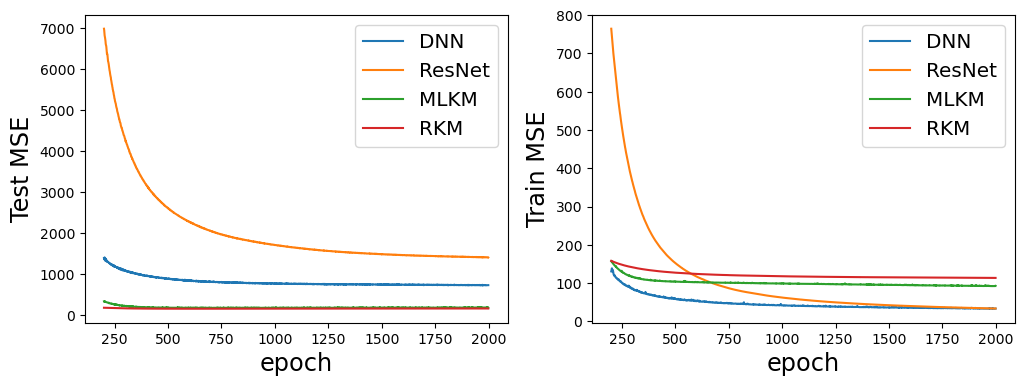

In [194]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_choose(ax[0],200,dnn_testloss)
plot_choose(ax[0],200,res_testloss)
plot_choose(ax[0],200,kernelnn_testloss)
plot_choose(ax[0],200,reskernel_testloss)
ax[0].legend(["DNN","ResNet","MLKM","RKM"],fontsize="x-large")
ax[0].set_xlabel("epoch",fontsize="xx-large")
ax[0].set_ylabel("Test MSE",fontsize="xx-large")

plot_choose(ax[1],200,dnn_trainloss)
plot_choose(ax[1],200,res_trainloss)
plot_choose(ax[1],200,kernelnn_trainloss)
plot_choose(ax[1],200,reskernel_trainloss)
ax[1].legend(["DNN","ResNet","MLKM","RKM"],fontsize="x-large")
ax[1].set_xlabel("epoch",fontsize="xx-large")
ax[1].set_ylabel("Train MSE",fontsize="xx-large")
plt.show()

## 3+. multi-layer learning (data splitting) 

In [77]:
#multi
split=2
layer=2
length=int(len(train_x)/layer)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

rff1=RandomFourierFeature(90,32,kernel='C',gamma=0.01)
rff2=RandomFourierFeature(8,8,kernel='G',gamma=0.1)

class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(32, 8)
        self.fc2 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = rff1.transform(x)
        x=self.fc1(x)
        x = rff2.transform(x)
        return self.fc2(x)


#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)
        
train_loaderset=[] # there are "split" elements
netset=[]
optimizerset=[]
train_loss=[]
test_loss=[]

np.random.seed(0)
row_rand_array = np.arange(train_x.shape[0])
np.random.shuffle(row_rand_array)

train_loaderset1=[]
for l in range(layer): #split into different dataset
    curx=train_x.values[row_rand_array[l*length:(l+1)*length]]
    cury=train_y.values[row_rand_array[l*length:(l+1)*length]]
    nnx = torch.from_numpy(curx).float()
    nny = torch.squeeze(torch.from_numpy(cury).float()) 
    train_loader = DataLoader(mydataset(nnx, nny),batch_size=100, shuffle=True)
    train_loaderset1.append(train_loader)
    
for i in range(split):
    train_loaderset1=train_loaderset1[1:]+train_loaderset1[0:1]
    train_loaderset.append(train_loaderset1)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = KernelNet()
    net = net.to(device)
    torch.manual_seed(1)
    net.apply(init_weights)
    netset.append(net)      
   
    optimizer1=[]
    optimizer1.append(optim.SGD([{'params': net.fc1.parameters()}],lr=8e-4,momentum=0.9,weight_decay=1e-4) )
    optimizer1.append(optim.SGD([{'params': net.fc2.parameters()}],lr=8e-4,momentum=0.9,weight_decay=1e-4) )
    optimizerset.append(optimizer1)
    
    train_loss.append(0)
    test_loss.append(0)
    
criterion=nn.MSELoss()    
loss=[]
alltrainloss=[[],[]]
alltestloss=[[],[]]
splkernel_trainloss=[]
splkernel_testloss=[]
t0 = time.time()
for epoch in range(2000): 
    for i in range(split):
        for l in range(layer):
            for x, y in train_loaderset[i][l]: #for batch, (x, y) in enumerate(train_loader): 
                # Data Splitting
                # every step, update a layer with smaller dataset 
                x, y = x.to(device), y.to(device)
                # Compute prediction error
                y_pred = netset[i](x)
                y_pred = torch.squeeze(y_pred)
                train_loss[i] = criterion(y_pred, y)
                alltrainloss[i].append(float(train_loss[i]))
                
                # Backpropagation
                optimizerset[i][l].zero_grad() 
                train_loss[i].backward()
                optimizerset[i][l].step()
    
    
    x0=torch.from_numpy(train_x[:].to_numpy()).float()
    for i in range(split):
        with torch.no_grad():
            x0 = x0.to(device)
            pred = netset[i](x0)
            train_loss[i] = mean_squared_error(train_y,pred)
            alltrainloss[i].append(float(train_loss[i]))
            
    
    x1=torch.from_numpy(test_x[:].to_numpy()).float()
    for i in range(split):
        with torch.no_grad():
            x1 = x1.to(device)
            pred = netset[i](x1)
            test_loss[i] = mean_squared_error(test_y,pred)
            alltestloss[i].append(float(test_loss[i]))
    
    if epoch>200 and float(sum(train_loss)/len(train_loss))>max(splkernel_trainloss[-200:-1]):
        break      
    
    if epoch % 100 == 0: 
        print(f'''epoch {epoch}
            Train set - loss: {sum(train_loss)/len(train_loss)}
            Test  set - loss: {sum(test_loss)/len(test_loss)}
            ''')
    splkernel_trainloss.append(float(sum(train_loss)/len(train_loss)))
    splkernel_testloss.append(float(sum(test_loss)/len(test_loss)))
    
        
dnn_fit = time.time() - t0
print("KernelNet(data splitting) complexity and model fitted in %.3f s" % dnn_fit)

epoch 0
            Train set - loss: 3708045.4488026034
            Test  set - loss: 3708913.2514313906
            
epoch 100
            Train set - loss: 1010.5696636351836
            Test  set - loss: 1457.571117120584
            
epoch 200
            Train set - loss: 295.4659065698513
            Test  set - loss: 429.39902019118273
            
epoch 300
            Train set - loss: 161.1248454350446
            Test  set - loss: 222.45547417307893
            
epoch 400
            Train set - loss: 138.06521155175352
            Test  set - loss: 179.67898627971607
            
epoch 500
            Train set - loss: 135.79310896513718
            Test  set - loss: 170.95050192097824
            
epoch 600
            Train set - loss: 136.4929840297571
            Test  set - loss: 169.4569278631111
            
KernelNet(data splitting) complexity and model fitted in 20.251 s


In [251]:
#original
#predict
temp=[]
parset=[]
for spl in range(split):
    par1=optimizerset[spl][0].param_groups[0]['params']
    for jj in range(1,split):
        par1=par1+optimizerset[spl][jj].param_groups[0]['params']
    parset.append(par1)
        
for spl in range(split):
    par=parset[spl]
    for i in range(len(train_x)):
        x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
        x0 = x0.to(device)
        pred = netset[spl](x0)
        fi=torch.tensor([])
        for j in range(len(par)):
            par[j].grad.data.zero_()
        pred.backward()   
        for j in range(len(par)): 
            fi=torch.cat([fi,par[j].grad.reshape(-1)])
        fi=fi.reshape(1,-1)
        if i==0:
            Fi=fi
        else:
            Fi=torch.cat([Fi,fi])   
    print(Fi.shape)
    temp.append(torch.linalg.inv(Fi.T @ Fi))
    
length=[]
coverage=0
mark=0
for i in range(len(test_x)):
    fFFf=0
    for spl in range(split):
        par=parset[spl]
        x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
        x0 = x0.to(device)
        pred = netset[spl](x0)
        #print(pred.detach().numpy()[0][0],test_y[i])
        par=parset[spl]
        f0=torch.tensor([])
        for j in range(len(par)):
            par[j].grad.data.zero_()
        pred.backward()
        for j in range(len(par)):
            f0=torch.cat([f0,par[j].grad.reshape(-1)])
        f0=f0.reshape(-1,1)
        fFFf=fFFf+f0.T @ temp[spl] @ f0
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=1.96*np.sqrt(float(fFFf/split**2+1))*np.sqrt(splkernel_trainloss[-1])
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<test_y[i] and pred.detach().numpy()[0][0]+dd>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark

print("n-p:",len(train_x)-f0.shape[0]," mark:",mark) 
print("length",np.mean(length))
print("95 coverage",coverage)

torch.Size([700, 273])
torch.Size([700, 273])
n-p: 427  mark: 300
length 54.98014755259159
95 coverage 0.9133333333333333


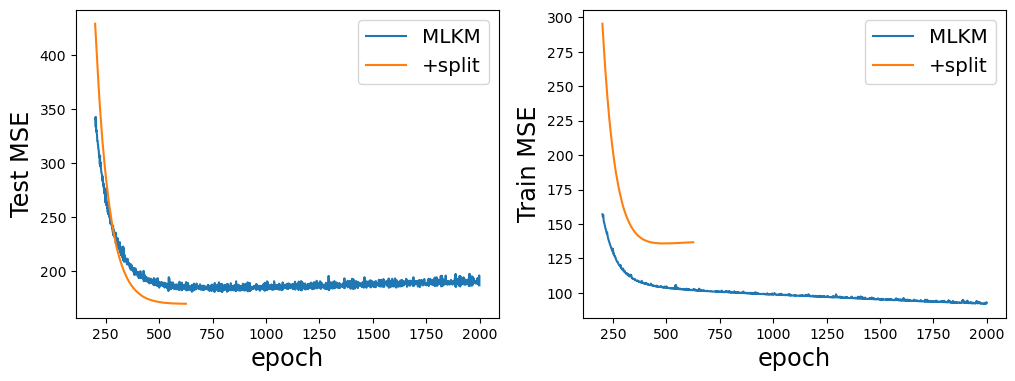

In [195]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_choose(ax[0],200,kernelnn_testloss)
plot_choose(ax[0],200,splkernel_testloss)
ax[0].legend(["MLKM","+split"],fontsize="x-large")
ax[0].set_xlabel("epoch",fontsize="xx-large")
ax[0].set_ylabel("Test MSE",fontsize="xx-large")

plot_choose(ax[1],200,kernelnn_trainloss)
plot_choose(ax[1],200,splkernel_trainloss)
ax[1].legend(["MLKM","+split"],fontsize="x-large")
ax[1].set_xlabel("epoch",fontsize="xx-large")
ax[1].set_ylabel("Train MSE",fontsize="xx-large")
plt.show()

## 4+. residual learning (data splitting) 

In [131]:
#res
split=2
layer=2
length=int(len(train_x)/layer)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=100, shuffle=False)

rff0=RandomFourierFeature(90,32,kernel='C',gamma=0.01)
rff1=RandomFourierFeature(8,8,kernel='G',gamma=0.1)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures,rff):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.rff=rff
        
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(outfeatures,outfeatures)
    
    def forward(self, x):
        rff=self.rff
        x = self.fc1(x)
        y = rff.transform(x)
        y = self.fc2(y)
        return x+y

class ResKernelNet(nn.Module): 
    def __init__(self):
        super(ResKernelNet, self).__init__()
        self.rblock1 = ResidualBlock(32,8,rff1)
        self.fc2 =nn.Linear(8,1)
 
    def forward(self, x):
        x = rff0.transform(x)
        x = self.rblock1(x)
        return self.fc2(x)


#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)
        
train_loaderset=[] # there are "split" elements
netset=[]
optimizerset=[]
alltrainloss=[[],[],[]]
alltestloss=[[],[],[]]
train_loss=[]
test_loss=[]

np.random.seed(0)
row_rand_array = np.arange(train_x.shape[0])
np.random.shuffle(row_rand_array)

train_loaderset1=[]
for l in range(layer): #split into different dataset
    curx=train_x.values[row_rand_array[l*length:(l+1)*length]]
    cury=train_y.values[row_rand_array[l*length:(l+1)*length]]
    nnx = torch.from_numpy(curx).float()
    nny = torch.squeeze(torch.from_numpy(cury).float()) 
    train_loader = DataLoader(mydataset(nnx, nny),batch_size=100, shuffle=True)
    train_loaderset1.append(train_loader)
    
for i in range(split):
    train_loaderset1=train_loaderset1[1:]+train_loaderset1[0:1]
    train_loaderset.append(train_loaderset1)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = ResKernelNet()
    net = net.to(device)
    torch.manual_seed(1)
    net.apply(init_weights)
    netset.append(net)      
   
    optimizer1=[]
    optimizer1.append(optim.SGD([{'params': net.rblock1.parameters()}],lr=1e-6,momentum=0.9,weight_decay=1e-4) )
    optimizer1.append(optim.SGD([{'params': net.fc2.parameters()}],lr=1e-6,momentum=0.9,weight_decay=1e-4) )
    optimizerset.append(optimizer1)
    
    train_loss.append(0)
    test_loss.append(0)
    
criterion=nn.MSELoss()    
loss=[]
splreskernel_trainloss=[]
splreskernel_testloss=[]
t0 = time.time()
for epoch in range(2000): 
    for i in range(split):
        for l in range(layer):
            for x, y in train_loaderset[i][l]: #for batch, (x, y) in enumerate(train_loader): 
                # Data Splitting
                # every step, update a layer with smaller dataset 
                x, y = x.to(device), y.to(device)
                # Compute prediction error
                y_pred = netset[i](x)
                y_pred = torch.squeeze(y_pred)
                train_loss[i] = criterion(y_pred, y)
                alltrainloss[i].append(float(train_loss[i]))
                
                # Backpropagation
                optimizerset[i][l].zero_grad() 
                train_loss[i].backward()
                optimizerset[i][l].step()
            
    
    x0=torch.from_numpy(train_x[:].to_numpy()).float()
    for i in range(split):
        with torch.no_grad():
            x0 = x0.to(device)
            pred = netset[i](x0)
            train_loss[i] = mean_squared_error(train_y,pred)
            alltrainloss[i].append(float(train_loss[i]))
            
    
    x1=torch.from_numpy(test_x[:].to_numpy()).float()
    for i in range(split):
        with torch.no_grad():
            x1 = x1.to(device)
            pred = netset[i](x1)
            test_loss[i] = mean_squared_error(test_y,pred)
            alltestloss[i].append(float(test_loss[i]))
    
    if epoch>200 and float(sum(train_loss)/len(train_loss))>max(splreskernel_trainloss[-200:-1]):
        break      
    
    if epoch % 100 == 0: 
        print(f'''epoch {epoch}
            Train set - loss: {sum(train_loss)/len(train_loss)}
            Test  set - loss: {sum(test_loss)/len(test_loss)}
            ''')
    splreskernel_trainloss.append(float(sum(train_loss)/len(train_loss)))
    splreskernel_testloss.append(float(sum(test_loss)/len(test_loss)))
            
        
dnn_fit = time.time() - t0
print("ResKernelNet(data splitting) complexity and model fitted in %.3f s" % dnn_fit)

epoch 0
            Train set - loss: 3963972.0947668916
            Test  set - loss: 3965323.1622700933
            
epoch 100
            Train set - loss: 548.0491265770473
            Test  set - loss: 535.019739453271
            
epoch 200
            Train set - loss: 273.0891440585043
            Test  set - loss: 302.7190818352749
            
epoch 300
            Train set - loss: 210.04917053413178
            Test  set - loss: 250.86413973400988
            
epoch 400
            Train set - loss: 181.710406652987
            Test  set - loss: 227.63556149487692
            
epoch 500
            Train set - loss: 166.76785199338838
            Test  set - loss: 215.1049074305594
            
epoch 600
            Train set - loss: 157.7257734813754
            Test  set - loss: 207.77141971357167
            
epoch 700
            Train set - loss: 151.5971637737751
            Test  set - loss: 203.00433053654928
            
epoch 800
            Train set - loss: 147.

In [132]:
#original
#predict
temp=[]
parset=[]
for spl in range(split):
    par1=optimizerset[spl][0].param_groups[0]['params']
    for jj in range(1,split):
        par1=par1+optimizerset[spl][jj].param_groups[0]['params']
    parset.append(par1)
        
for spl in range(split):
    par=parset[spl]
    for i in range(len(train_x)):
        x0=torch.from_numpy(train_x[i:1+i].to_numpy()).float()
        x0 = x0.to(device)
        pred = netset[spl](x0)
        fi=torch.tensor([])
        for j in range(len(par)):
            par[j].grad.data.zero_()
        pred.backward()   
        for j in range(len(par)): 
            fi=torch.cat([fi,par[j].grad.reshape(-1)])
        fi=fi.reshape(1,-1)
        if i==0:
            Fi=fi
        else:
            Fi=torch.cat([Fi,fi])   
    print(Fi.shape)
    temp.append(torch.linalg.inv(Fi.T @ Fi))
    
length=[]
coverage=0
mark=0
for i in range(len(test_x)):
    fFFf=0
    for spl in range(split):
        par=parset[spl]
        x0=torch.from_numpy(test_x[i:i+1].to_numpy()).float()
        x0 = x0.to(device)
        pred = netset[spl](x0)
        #print(pred.detach().numpy()[0][0],test_y[i])
        par=parset[spl]
        f0=torch.tensor([])
        for j in range(len(par)):
            par[j].grad.data.zero_()
        pred.backward()
        for j in range(len(par)):
            f0=torch.cat([f0,par[j].grad.reshape(-1)])
        f0=f0.reshape(-1,1)
        fFFf=fFFf+f0.T @ temp[spl] @ f0
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=1.96*np.sqrt(float(fFFf/split**2+1))*np.sqrt(splreskernel_trainloss[-1])
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<test_y[i] and pred.detach().numpy()[0][0]+dd>test_y[i]:
        coverage=coverage+1
coverage=coverage/mark

print("n-p:",len(train_x)-f0.shape[0]," mark:",mark) 
print("length",np.mean(length))
print("95 coverage",coverage)

torch.Size([700, 345])
torch.Size([700, 345])
n-p: 355  mark: 270
length 53.31541725133678
95 coverage 0.9296296296296296


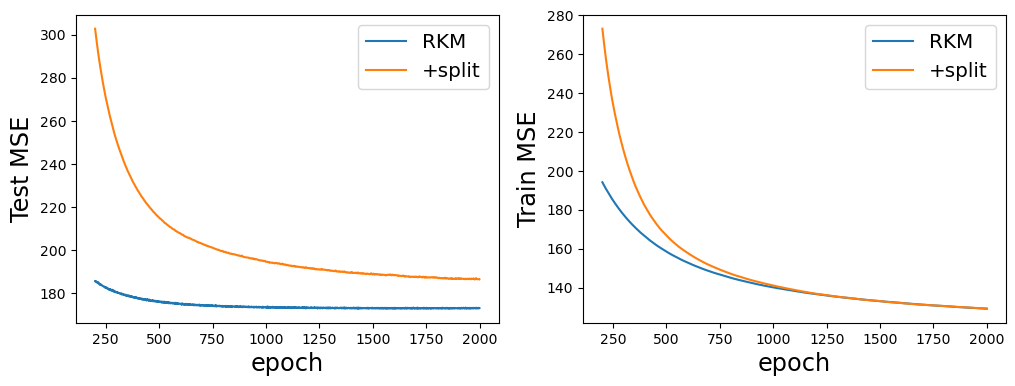

In [133]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_choose(ax[0],200,reskernel_testloss)
plot_choose(ax[0],200,splreskernel_testloss)
ax[0].legend(["RKM","+split"],fontsize="x-large")
ax[0].set_xlabel("epoch",fontsize="xx-large")
ax[0].set_ylabel("Test MSE",fontsize="xx-large")

plot_choose(ax[1],200,reskernel_trainloss)
plot_choose(ax[1],200,splreskernel_trainloss)
ax[1].legend(["RKM","+split"],fontsize="x-large")
ax[1].set_xlabel("epoch",fontsize="xx-large")
ax[1].set_ylabel("Train MSE",fontsize="xx-large")
plt.show()

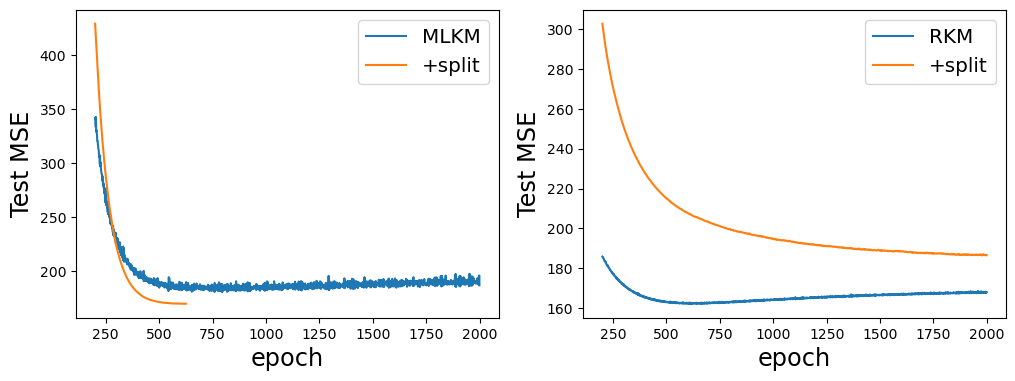

In [196]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_choose(ax[0],200,kernelnn_testloss)
plot_choose(ax[0],200,splkernel_testloss)
ax[0].legend(["MLKM","+split"],fontsize="x-large")
ax[0].set_xlabel("epoch",fontsize="xx-large")
ax[0].set_ylabel("Test MSE",fontsize="xx-large")

plot_choose(ax[1],200,reskernel_testloss)
plot_choose(ax[1],200,splreskernel_testloss)
ax[1].legend(["RKM","+split"],fontsize="x-large")
ax[1].set_xlabel("epoch",fontsize="xx-large")
ax[1].set_ylabel("Test MSE",fontsize="xx-large")
plt.show()

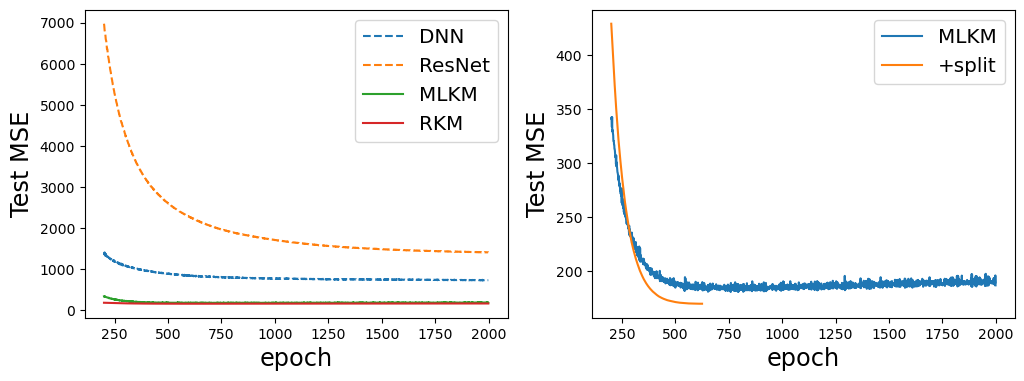

In [197]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_choose(ax[0],200,dnn_testloss,linestyle="--")
plot_choose(ax[0],200,res_testloss,linestyle="--")
plot_choose(ax[0],200,kernelnn_testloss)
plot_choose(ax[0],200,reskernel_testloss)
ax[0].legend(["DNN","ResNet","MLKM","RKM"],fontsize="x-large")
ax[0].set_xlabel("epoch",fontsize="xx-large")
ax[0].set_ylabel("Test MSE",fontsize="xx-large")

plot_choose(ax[1],200,kernelnn_testloss)
plot_choose(ax[1],200,splkernel_testloss)
ax[1].legend(["MLKM","+split"],fontsize="x-large")
ax[1].set_xlabel("epoch",fontsize="xx-large")
ax[1].set_ylabel("Test MSE",fontsize="xx-large")
plt.show()